In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec



In [5]:
#Load data

data_path = '/home/belysetag/Desktop/text-classification-nlp/data/alldata_1_for_kaggle.csv'
df = pd.read_csv(data_path, encoding='latin-1')

print(f'Shape: {df.shape}')
print(f'Columns: {list(df.columns)}')

Shape: (7570, 3)
Columns: ['Unnamed: 0', '0', 'a']


In [6]:
df.columns = ['Serial_Number', 'Target_Labels', 'Research_Text']

In [7]:
print(df.dtypes)
print('\n Missing Values')
print(df.isnull().sum())

Serial_Number     int64
Target_Labels    object
Research_Text    object
dtype: object

 Missing Values
Serial_Number    0
Target_Labels    0
Research_Text    0
dtype: int64


In [8]:
#check duplicate
print(f'Number of Duplicates: {df.duplicated().sum()}')

Number of Duplicates: 0


In [9]:
df.head()

,Serial_Number,Target_Labels,Research_Text
0,0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Serial_Number  7570 non-null   int64 
 1   Target_Labels  7570 non-null   object
 2   Research_Text  7570 non-null   object
dtypes: int64(1), object(2)
memory usage: 177.6+ KB


In [11]:
print(f'Final Shape: {df.shape}')
print(df['Target_Labels'].value_counts())

Final Shape: (7570, 3)
Target_Labels
Thyroid_Cancer    2810
Colon_Cancer      2580
Lung_Cancer       2180
Name: count, dtype: int64


In [12]:
# Drop unnecessary columns
df = df.drop(columns=['Serial_Number'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7570 entries, 0 to 7569
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Target_Labels  7570 non-null   object
 1   Research_Text  7570 non-null   object
dtypes: object(2)
memory usage: 118.4+ KB


In [14]:
df.head()

,Target_Labels,Research_Text
0,Thyroid_Cancer,Thyroid surgery in children in a single insti...
1,Thyroid_Cancer,""" The adopted strategy was the same as that us..."
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï¬b...
3,Thyroid_Cancer,Solitary plasmacytoma SP of the skull is an u...
4,Thyroid_Cancer,This study aimed to investigate serum matrix ...


In [15]:
def clean_text(text):
    """
    Cleans medical text documents while preserving clinically meaningful tokens.

    Removes:
    - URLs and web references
    - HTML tags and markup
    - Emojis
    - Unnecessary punctuation (except hyphens and apostrophes)
    - Extra whitespace

    Preserves:
    - Numbers (e.g., TP53, T3N1M0, CA 19-9)
    - Hyphenated medical terms (e.g., non-small-cell)
    - Apostrophes for medical/statistical terms (e.g., Fisher's, Student's, 3'UTR)
    - Citations as markers (e.g., [1,2,3] → [CITATION])

    Args:
        text (str): Raw text document

    Returns:
        str: Cleaned text
    """

    # Lowercasing
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove emojis
    text = re.sub(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags
        "]+",
        '',
        text
    )

    # Replace citations [1,2,3] style with marker (preserves context)
    text = re.sub(r'\[\d+(?:,\s*\d+)*\]', ' [CITATION] ', text)

    # Replace slashes with space (preserve meaning for ratios like ER/PR)
    text = re.sub(r'/', ' ', text)

    # Remove punctuation except hyphens and apostrophes
    # Keeps letters, numbers, whitespace, hyphens, and apostrophes
    text = re.sub(r"[^\w\s\-']", ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [16]:
df['Research_Text'] = df['Research_Text'].apply(clean_text)
df.head()

,Target_Labels,Research_Text
0,Thyroid_Cancer,thyroid surgery in children in a single instit...
1,Thyroid_Cancer,the adopted strategy was the same as that used...
2,Thyroid_Cancer,coronary arterybypass grafting thrombosis ï br...
3,Thyroid_Cancer,solitary plasmacytoma sp of the skull is an un...
4,Thyroid_Cancer,this study aimed to investigate serum matrix m...


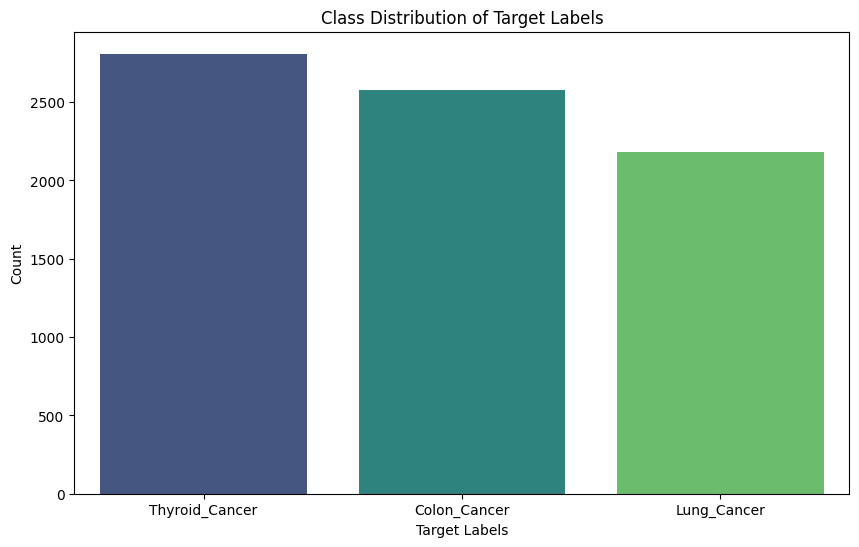

In [17]:
# Visualize class distribution
plt.figure(figsize=(10,6))
sns.countplot(x='Target_Labels', hue='Target_Labels', data=df, palette='viridis', legend=False)
plt.title('Class Distribution of Target Labels')
plt.xlabel('Target Labels')
plt.ylabel('Count')
plt.show()


## Class Distribution of Target Labels
This bar chart illustrates how the dataset is distributed across the three cancer types. Thyroid cancer has the highest number of samples (about 2,800), followed by colon cancer with around 2,600 samples, while lung cancer has the fewest at approximately 2,200 samples.

Insight: Overall, the dataset is fairly well balanced, with no major class imbalance. Although thyroid cancer is slightly overrepresented, the difference is not significant and should not negatively affect model training.

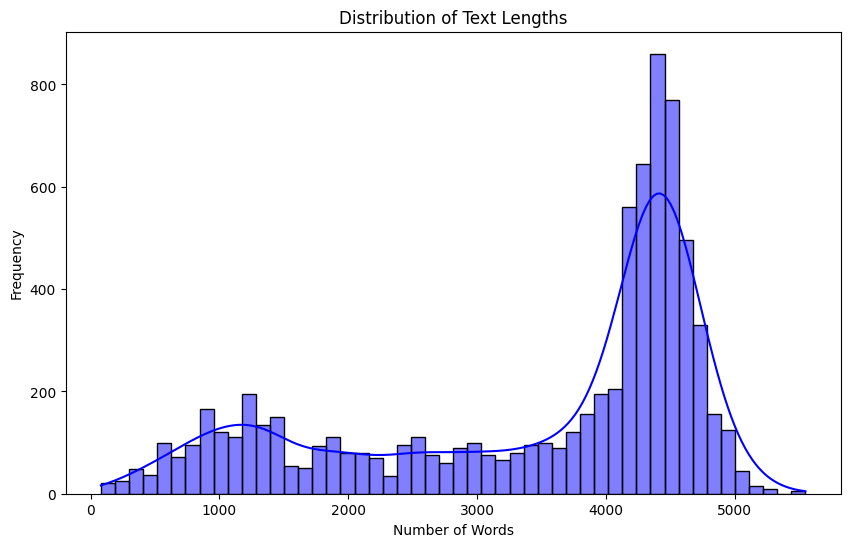

In [18]:
# Visualize Document Length Distribution
df['Text_Length'] = df['Research_Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.histplot(df['Text_Length'], bins=50, kde=True, color='blue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

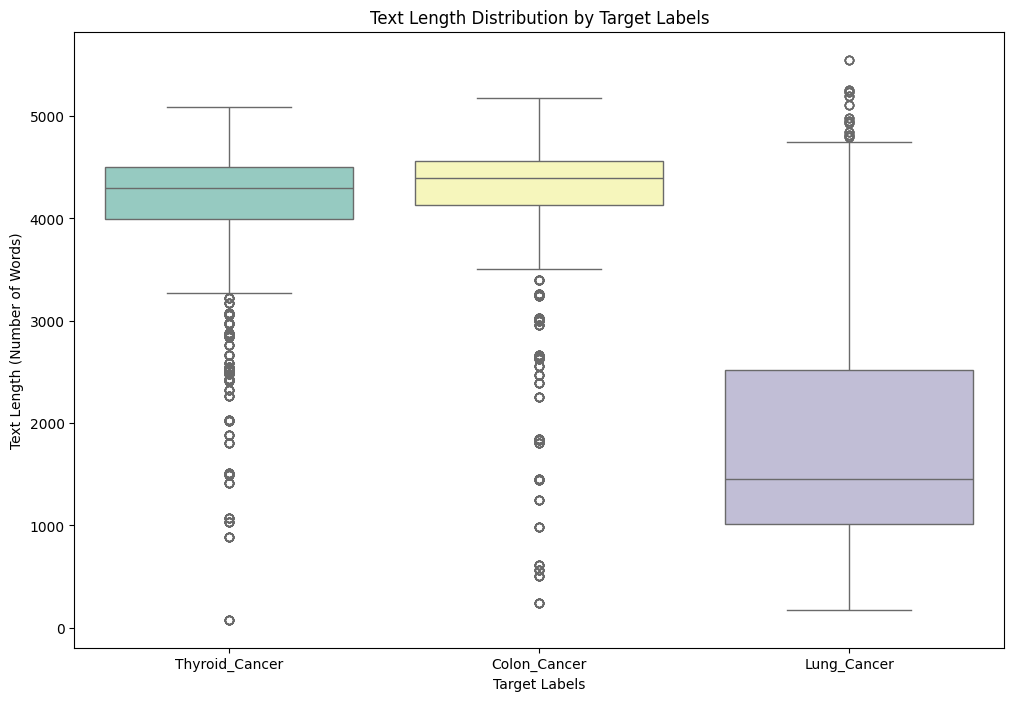

In [19]:
#visualize Text Length by Class
plt.figure(figsize=(12,8))
sns.boxplot(x='Target_Labels', y='Text_Length', hue='Target_Labels', data=df, palette='Set3', legend=False)
plt.title('Text Length Distribution by Target Labels')
plt.xlabel('Target Labels')
plt.ylabel('Text Length (Number of Words)')
plt.show()


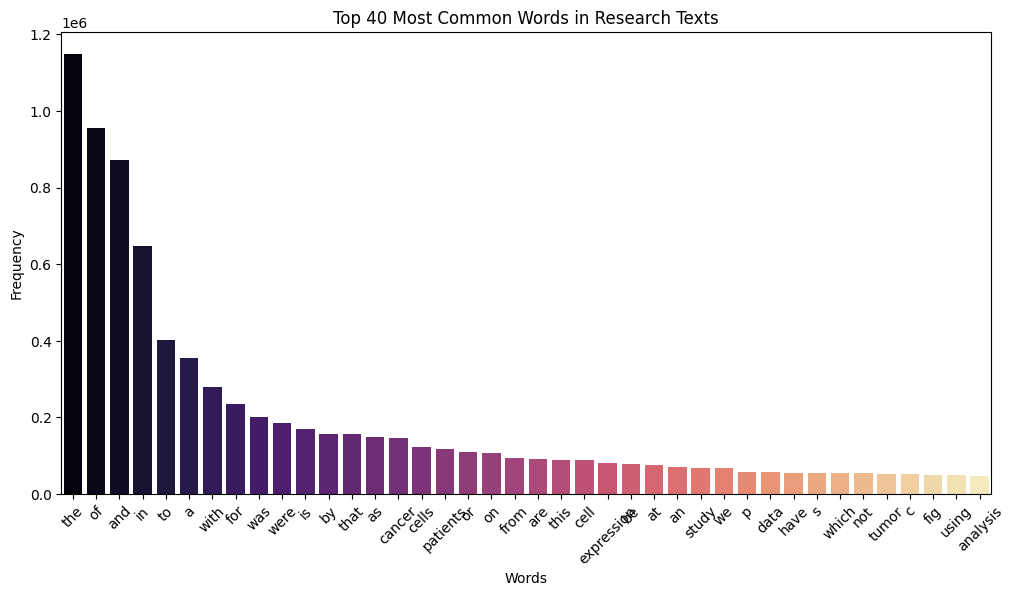

In [20]:
#Visualize Vocabulary Size / Word Frequency
all_words = ' '.join(df['Research_Text']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(40)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts), hue=list(words), palette='magma', legend=False)
plt.title('Top 40 Most Common Words in Research Texts')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [21]:
# removing stop words
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from text
def remove_stopwords(text):
    """
    Remove stopwords from text while preserving medical terminology.
    
    Args:
        text (str): Cleaned text
        
    Returns:
        str: Text with stopwords removed
    """
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply stopwords removal
df['Research_Text'] = df['Research_Text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/belysetag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


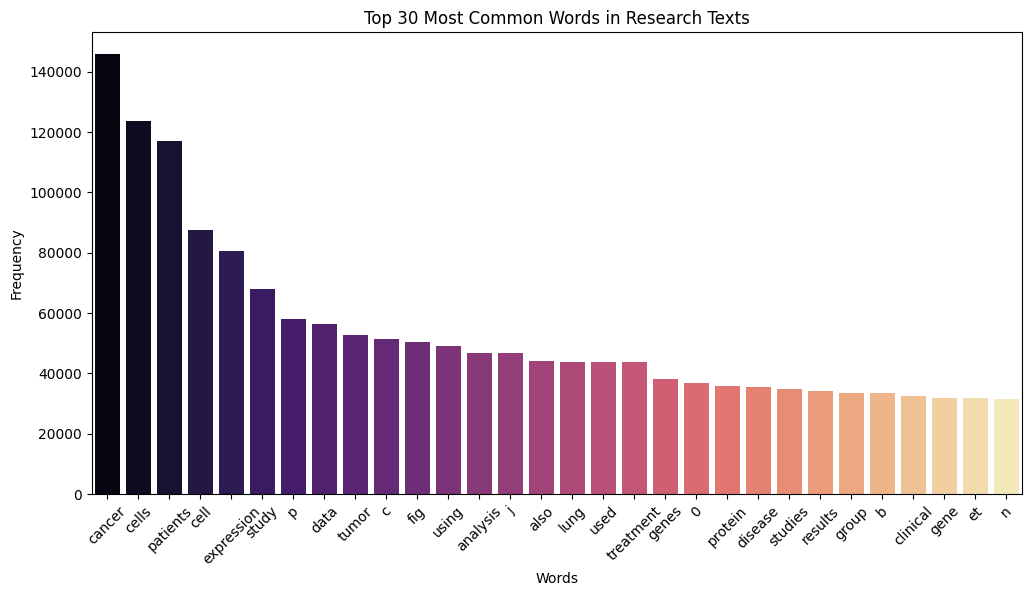

In [22]:
#Visualize Vocabulary Size / Word Frequency
all_words = ' '.join(df['Research_Text']).split()
word_freq = Counter(all_words)
most_common_words = word_freq.most_common(30)
words, counts = zip(*most_common_words)
plt.figure(figsize=(12,6))
sns.barplot(x=list(words), y=list(counts), hue=list(words), palette='magma', legend=False)
plt.title('Top 30 Most Common Words in Research Texts')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [23]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer with optimized parameters
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,           # Limit to top 5000 features to avoid high dimensionality
    min_df=2,                    # Ignore terms appearing in fewer than 2 documents
    max_df=0.8,                  # Ignore terms appearing in more than 80% of documents
    ngram_range=(1, 2),          # Use unigrams and bigrams (e.g., "lung cancer")
    sublinear_tf=True,           # Apply sublinear TF scaling
    lowercase=True               # Already done, but ensures consistency
)

# Fit and transform the research texts
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Research_Text'])

print(f"TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"Features (Vocabulary Size): {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Sparsity: {1.0 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])):.2%}")


TF-IDF Matrix Shape: (7570, 5000)
Features (Vocabulary Size): 5000
Sparsity: 87.81%



TF-IDF Matrix Statistics:
--------------------------------------------------
Mean TF-IDF per Document........... 0.0041
Max TF-IDF Score................... 0.4355
Min TF-IDF Score................... 0.0000
Median Non-Zero Values............. 609.2775
Total Non-Zero Entries............. 4,612,231
Total Possible Entries............. 37,850,000


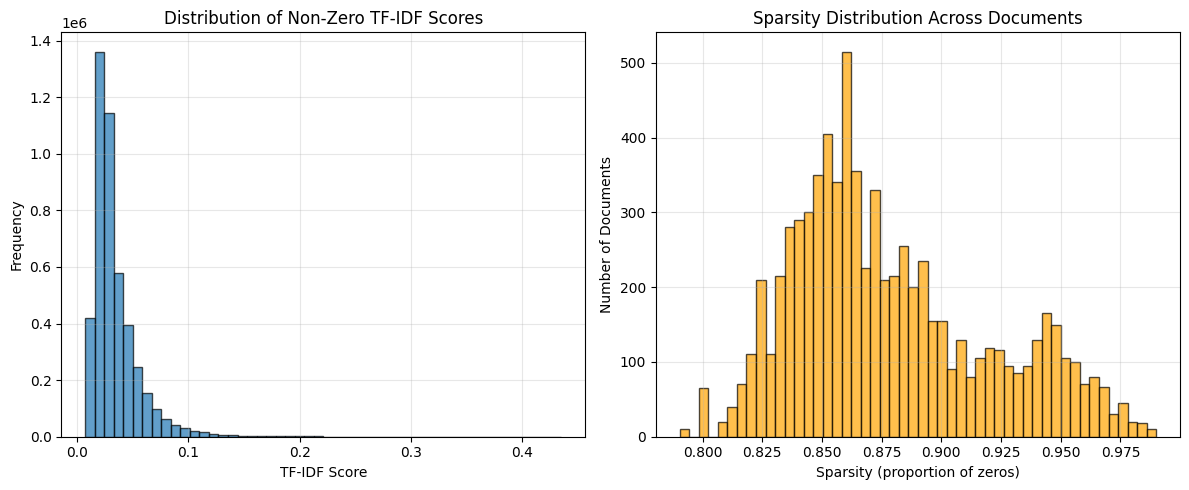


Average Sparsity per Document: 87.81%


In [24]:
# Visualize TF-IDF Distribution Statistics
tfidf_stats = {
    'Mean TF-IDF per Document': tfidf_matrix.mean(axis=1).A1.mean(),
    'Max TF-IDF Score': tfidf_matrix.max(),
    'Min TF-IDF Score': tfidf_matrix.min(),
    'Median Non-Zero Values': np.median(tfidf_matrix.nnz / tfidf_matrix.shape[0]),
    'Total Non-Zero Entries': tfidf_matrix.nnz,
    'Total Possible Entries': tfidf_matrix.shape[0] * tfidf_matrix.shape[1]
}

print("\nTF-IDF Matrix Statistics:")
print("-" * 50)
for stat_name, stat_value in tfidf_stats.items():
    if isinstance(stat_value, float):
        print(f"{stat_name:.<35} {stat_value:.4f}")
    else:
        print(f"{stat_name:.<35} {stat_value:,}")

# Visualize TF-IDF scores distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(tfidf_matrix.data, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Non-Zero TF-IDF Scores')
plt.xlabel('TF-IDF Score')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sparsity_per_doc = 1 - (tfidf_matrix.getnnz(axis=1) / tfidf_matrix.shape[1])
plt.hist(sparsity_per_doc, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.title('Sparsity Distribution Across Documents')
plt.xlabel('Sparsity (proportion of zeros)')
plt.ylabel('Number of Documents')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage Sparsity per Document: {sparsity_per_doc.mean():.2%}")
